In [ ]:
import numpy as np 
import matplotlib.pylab as plt 
from ml_collections import ConfigDict
import scipy.stats 
from scipy.integrate import simpson
from scipy.interpolate import interp1d

from getdist import plots, MCSamples
import getdist

# our scripts
from src.cosmo import calculate_pk_fixed_redshift
from config import get_config

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [ ]:
configs = get_config()

In [ ]:
npower = 15 
omega_cdm_min = 0.10 
omega_cdm_max = 0.25

wavenumbers = np.geomspace(configs.grid.kmin, configs.grid.kmax, configs.grid.nk)
omega_cdm_grid = np.linspace(omega_cdm_min, omega_cdm_max, npower)
cosmo = {'omega_cdm': 0.10, 'omega_b': 0.022, 'S_8': 0.75, 'n_s': 1.0, 'h': 0.75}

In [ ]:
record_pk = list()

for i in range(npower):
    cosmo['omega_cdm'] = omega_cdm_grid[i]
    pk = calculate_pk_fixed_redshift(configs, cosmo, 0)
    record_pk.append(pk)

In [ ]:
record_pk = np.asarray(record_pk)

## Total Power Spectrum

In [ ]:
nbias = len(configs.bias.fiducial)
bias_prod = np.outer(configs.bias.fiducial, configs.bias.fiducial)
bias_prod = bias_prod[np.triu_indices(nbias)].reshape(1, -1)
total_pk = np.dot(bias_prod, record_pk).reshape(-1)

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(npower):
    plt.loglog(wavenumbers, record_pk[i], lw = 2)
plt.loglog(wavenumbers, total_pk, lw = 3)
plt.xlim(configs.grid.kmin, configs.grid.kmax)
plt.ylabel(r'$P_{\delta}(k, z=0)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

## Noisy $P_{\delta}$

In [ ]:
sigma = np.ones(configs.grid.nk) * total_pk * 0.20
noise = np.random.randn(configs.grid.nk) * sigma
data = total_pk + noise

In [ ]:
plt.figure(figsize = (12, 8))
plt.loglog(wavenumbers, total_pk, lw = 3, label = 'Total Power Spectrum (Fiducial)')
plt.errorbar(wavenumbers, data, yerr=sigma, fmt = 'ro', label = 'Noisy Power Spectrum')
plt.xlim(configs.grid.kmin, configs.grid.kmax)
plt.ylabel(r'$P_{\delta}(k, z=0)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':20})
plt.show()

## Sampling

In [ ]:
def calculate_theory(bias: dict, power_spectra: np.ndarray) -> np.ndarray:
    """
    bias: len(bias) = 5 
    power_spectra: shape = 15 x 100
    """
    nbias = len(bias)
    bias = list(bias.values())
    bias_prod = np.outer(bias, bias)
    bias_prod = bias_prod[np.triu_indices(nbias)].reshape(1, -1)
    total_pk = np.dot(bias_prod, power_spectra).reshape(-1)
    return total_pk

In [ ]:
def calculate_log_likelihood(data: np.ndarray, theory: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    diff = (data - theory )/sigma
    return -0.5 * np.sum(diff * diff)    

In [ ]:
def generate_bias_prior(config: ConfigDict) -> dict:
    """Generates the entity of each parameter by using scipy.stats function.
    Args:
        dictionary (dict): A dictionary with the specifications of the prior.
    Returns:
        dict: the prior distribution of all parameters.
    """
    dictionary = dict()
    for i, key in enumerate(config.bias.names):
        specs = (config.bias.loc[i], config.bias.scale[i])
        dictionary[key] = getattr(scipy.stats, config.bias.distribution)(*specs)
    return dictionary

In [ ]:
# test_bias = np.array([0.9, 1.4, 1.9, 2.4, 2.8])
test_bias = dict(zip(configs.bias.names, configs.bias.fiducial))
test = calculate_theory(test_bias, record_pk)

In [ ]:
calculate_log_likelihood(data, test, sigma)

## Test on a Grid

In [ ]:
def distribution(bias_param: dict, bias_prior, ref = 'b0'):
    theory = calculate_theory(bias_param, record_pk)
    loglike = calculate_log_likelihood(data, theory, sigma)
    logprior = bias_prior[ref].logpdf(bias_param[ref])
    return np.exp(loglike + logprior)

In [ ]:
def pdf_cdf(configs, bias_grid: np.ndarray, bias_params, bias_prior, ref = 'b0'):
    ngrid = len(bias_grid)
    bias_params = bias_params.reshape(1, -1)
    bias_repeat = np.repeat(bias_params, ngrid, axis = 0)
    idx = configs.bias.names.index(ref)
    bias_repeat[:, idx] = bias_grid
    
    pdfs = list()
    for b in bias_repeat:
        bparam = dict(zip(configs.bias.names, b))
        pdfs.append(distribution(bparam, bias_prior, ref))
    
    pdf = pdfs/simpson(pdfs, bias_grid)
    cdf = np.cumsum(pdf)
    cdf /= max(cdf)
    return pdf, cdf

In [ ]:
def sample_bias(nsample, configs, bias_grid, bias_params, bias_prior, ref = 'b0'):
    u = np.random.uniform(0, 1, nsample)
    pdf, cdf = pdf_cdf(configs, bias_grid, bias_params, bias_prior, ref)
    func_interp = interp1d(cdf, bias_grid)
    samples = func_interp(u)
    return samples

In [ ]:
bgrid = np.linspace(0, 5, 1000)
bfid = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
priors = generate_bias_prior(configs)

In [ ]:
record_bias = dict()
for bname in configs.bias.names:
    pdf, cdf = pdf_cdf(configs, bgrid, bfid, priors, bname)
    samples = sample_bias(10000, configs, bgrid, bfid, priors, bname)
    record_bias[bname] = (pdf, cdf, samples)

In [ ]:
for bname in configs.bias.names:
    print(f'{bname}: {bgrid[np.argmax(record_bias[bname][0])]:.4f}')

In [ ]:
maxpdf = list()
plt.figure(figsize = (12, 8))
for bname in configs.bias.names:
    pdf, cdf, samples = record_bias[bname]
    plt.plot(bgrid, pdf)
    plt.hist(samples, density=True, bins=20, alpha = 0.5)
    maxpdf.append(np.max(pdf))
plt.ylabel(r'$p(b_{\alpha})$', fontsize = fontSize)
plt.xlabel(r'$b_{\alpha}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2 * np.max(maxpdf))
plt.xlim(0, 5)
plt.show()

# Gibbs Sampling

In [ ]:
bgrid = np.linspace(0, 5, 100)
bfid = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
priors = generate_bias_prior(configs)

In [ ]:
ngibbs = 10000
trace = np.zeros((ngibbs, 5))

for g in range(ngibbs):
    for i, bname in enumerate(configs.bias.names):
    
        param = sample_bias(1, configs, bgrid, bfid, priors, bname)
        bfid[i] = param        
    trace[g] = bfid

## Triangle Plot

In [ ]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels =  [r"$b_{0}$", r"$b_{1}$", r"$b_{2}$", r"$b_{s}$", r"$b_{\nabla}$"]
samples = MCSamples(samples=trace,names = names, labels = labels, settings = settings)

In [ ]:
G = plots.getSubplotPlotter(subplot_size=2)
samples.updateSettings({'contours': contours})
G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':'blue'}, contour_colors=['blue'])
G.settings.num_plot_contours = 2
G.settings.solid_contour_palefactor = 0.5
G.settings.alpha_filled_add = 0.2

for i in range(0,5):
    for j in range(0, i+1):
        if i != j:
            ax = G.subplots[i,j]
            
            a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
            density = G.sample_analyser.get_density_grid(samples, a, b)
            density.contours = density.getContourLevels(contours)
            contour_levels = density.contours
            
            ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = 'blue', linewidths = linewidth) 
            ax.tick_params(axis = 'x', labelsize = fontSize, rotation=45, pad=5)
            ax.tick_params(axis = 'y', labelsize = fontSize, pad=5)
            ax.yaxis.label.set_size(fontSize)
            ax.xaxis.label.set_size(fontSize)
            ax.xaxis.labelpad = 20
            ax.yaxis.labelpad = 20
        else:
            ax = G.subplots[i,j]   
            
            dense = samples.get1DDensity('x'+str(i))
            dense.normalize(by='max')
            ax.plot(dense.x, dense.P, lw = linewidth, c = 'blue')
            
            ax.tick_params(axis = 'x', labelsize = fontSize, rotation=45, pad=5)
            ax.tick_params(axis = 'y', labelsize = fontSize, pad=5)
            ax.yaxis.label.set_size(fontSize)
            ax.xaxis.label.set_size(fontSize)
            ax.xaxis.labelpad = 20
            ax.yaxis.labelpad = 20
plt.show()

## Experiment: Kernel Interpolation

In [1]:
import torch
import matplotlib.pylab as plt 

# our script and functions 
from src.interpolation import KernelInterpolation 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
fontSize = 20

In [2]:
xmin = 0.0 
xmax = 2.0 * torch.pi 
ndata = 25
Ndata = 500
x = torch.linspace(xmin, xmax, ndata)
xnew = torch.linspace(xmin, xmax, Ndata)
y = torch.sin(x)

In [3]:
interp = KernelInterpolation(x, y, hyperparam=1.0)
ynew = interp.predict(xnew)

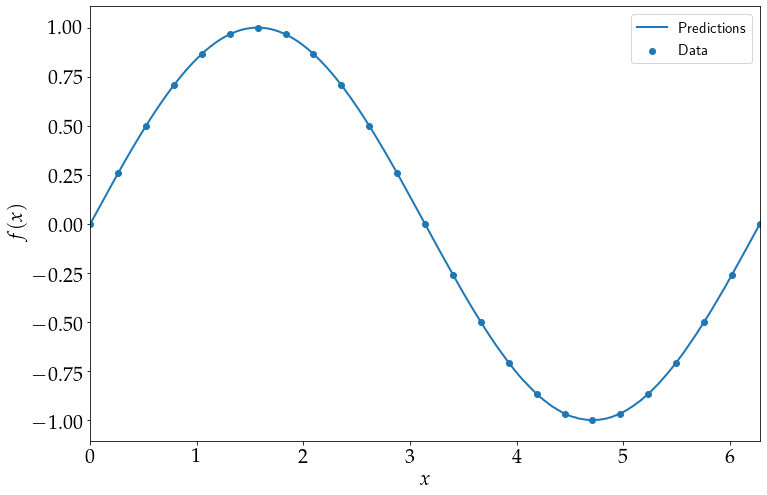

In [4]:
plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Data')
plt.plot(xnew, ynew, lw = 2, label = 'Predictions')
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(xmin, xmax)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()